<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/Models_multiinput/multiclassclasif_with_autoencoder_gt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plantamiento

Tengo un autoencoder puta madre que me lo simplifica todo.

Los elementos Helio y Proton los confunde muchísimo por motivos obvios, se parecen demasiado encuanto a masa y eso.

EL nitrogeno y el Litio supongo que tambien los confunde mucho.

Con el electron y el gamma ya no tenemso mucho problema porque con varios telescopios si es capaz de ver bien cual es cual.

1.- Vamos a probar un modelo con el autoencoder y 1  y luego 4 telescopio que clasifique gamma-electron-iron-proton/helio-litio/nitrogeno (5 clases). Y vemos que tal sale.

2.- (si va bien lo anterior) Voy a crear un modelo altamente personalizable y los vamos a meter a simular con muchos hiperparametros.

#Cargamos las librerias

In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

#Creamos modelo 1 telescopio

In [ ]:
def model_1_tel(input_shape=(55,93,1),filtros=None,batch_init=True,last_layers=None,avg_pooling=False,classes=7,learning_rate=1e-5,first_model=None,first_part=False):
    if filtros is None:
        filtros=[[64,32],[128,64,64],[32,16]]
    if last_layers is None:
        last_layer=[35,20]
    #lo vamos a hacer super customizable para probar esa vaina de entrenar muchos hiperparametros
    #estructura lo que nos mete son el numero de filtros conv y maxpool
    model=tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape)])
    if first_model:
        first_model.trainable=False
        model.add(first_model)
    if batch_init:
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
    for i,j in enumerate(filtros):
        #aqui se alterna entre conv y maxpool(1) o average pool(-1)
        for k in j:
            model.add(tf.keras.layers.Conv2D(k,3,activation="relu"))
        if avg_pooling:
            model.add(tf.keras.layers.AveragePooling2D((2,2)))
        else:
            model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    if first_part:
        return model
    for j,i in enumerate(last_layers):
        model.add(tf.keras.layers.Dense(i,activation="relu"))
    model.add(tf.keras.layers.Dense(classes,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


In [ ]:
modelo_input=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/autoencoder_ground_truth_2_largetrain_out5292.h5")
a=model_1_tel((55,93,1),filtros=[[64,32],[128,64,64],[320,16]],batch_init=True,last_layers=[30,15],first_model=modelo_input)
a.summary()
tf.keras.utils.plot_model(a,show_shapes=True,expand_nested=True)

# Carga de datos

In [ ]:
#funciones para la carga de datos

def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
                return None
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    for i,j in enumerate(tels):
        indices=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    #nos devuelve un array con tantas listas como telescopios con el indice donde estan los eventos con 
    #igual numero de evento
    #indices_master=[tel1:[eventos para la run],tel2:[eventos para la run]...]
    return np.array(indices_master)




def fill_holes(npy):
    npy_aux=npy.copy()
    if type(npy)!=np.ndarray:
        print("Error input")
        return
    #para cada elemento que sea cero lo rellenamos con la media de los vecinos
    indices=np.where(npy[1:-1,1:-1]==0)
    indices_1=indices[1]+1
    indices_0=indices[0]+1
    for i in range(indices_1.shape[0]):
        #esto se podría vectorizar
        media=(npy[indices_0[i]-1,indices_1[i]]+npy[indices_0[i],indices_1[i]-1]+npy[indices_0[i]+1,indices_1[i]]+npy[indices_0[i],indices_1[i]+1])/4
        npy_aux[indices_0[i],indices_1[i]]=media
    del npy
    return npy_aux


def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=False,ending=".npy"):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los archivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera
    #el indices runs es para que solo nos devuelva los que queremos de cada archivo

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray)):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
                    return None
    else:
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
                return None


    if only_names:
        return lista
    else:
        if indices_runs is not None:
            
            if indices_runs[0].size==0:
            #Esta comprobacion la hacemos porque no sabemos si no comportarten ningun evento para esa primera run
                no_salir=True
                i=1
                while no_salir:
                    if indices_runs[i].size==0:
                        i+=1
                    else:
                        lista_npy=np.load(lista[i])[indices_runs[i]]
                        no_salir=False
                        i+=1
                for m,k in enumerate(lista[i:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy

        else:
            lista_npy=np.load(lista[0])
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
            return lista_npy



#esta es la funcion master que lo junta todo en uno
#aqui indicamos los elementos que queremos que estén diferenciados en la clasificacion, así
#como las runs que queremos de cada uno de ellos
def load_dataset_ensemble(base_dir,elementos_clasif,pre_name_folders="npy_",telescopios=None,lista_list_runs=None,elementos=None,test_size=0.2,same_quant=False):
    #telescopios deb ser una lista , aunque solo haya uno 1
    #esta funcion es una version de load_dataset donde puedes escoger cuantas runs de cada elemento,
    #tambien (como en la otra, puedes decidir que haya mas o menos las mismas de todas same_quant)
    #list_RUNS Ahora es una lista de listas indicando para cada telescopio los indices de las runs 
    #indicamos los elementos que queremos que sean tomados en cuenta, pero el resto se les pone una label igual

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            print(j,k,list_runs,aux_events.shape)
            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    print("_______________")
    last_aux_decider=0
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if same_quant:
                media=int(np.median(numero_eventos))
                data_aux=data_aux[:media]
            print(j,k,data_aux.shape)
            if l==0:
                if j in elementos_clasif:
                    aux_decider=last_aux_decider+1
                    last_aux_decider+=1
                else:
                    aux_decider=0
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.ones(label_size)*aux_decider
                data=data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*aux_decider),axis=0)
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list

#lo que nosotros necesitamos ahora es, poder indicar el telescopio del que queremos las runs
#los elementos que deben ir a la misma clasificación (mismo label), e indicar cuantas runs queremos de cada uno de ellos
#tambíen es importante que se pueda testar con un numero igual de features y asi tener un porcentaje de acierto real y no sesgado.

def load_dataset_completo(base_dir,labels_asign=None,elementos=None,lista_list_runs=None,pre_name_folders="npy_",telescopios=None,test_size=0.2,same_quant="same",verbose=True,fill=False):
    #LOS TELESCOPIOS EN UNA LISTA AUNQUE SEA 1
    #la estructura de datos esperada es una carpeta contenedora de las carpetas con los archivos npy
    #y prename folder es eso que va delante del nombre de la carpeta que tiene el nombre del elemento

    #poniendo las labels nosotros podemos escoger que dos entren dentro de la misma categoria 
    #a la hora de poner las labels_asign hay que tener en cuenta que si ponemos [0,1,2,6]
    #aunque solo haya 4 clases, se pensara que hay 7 pues va de 0 hasta 6. Siempre empieza en 0 y no puede saltarse ningun numero.

    #en él se indica los elementos que vamos a usar así como las labels que van a tener 
    #por ultimo da igual qeu tomemos muchas runs de uno si ponemos same_quant=same se nos quedará la cantidad exacata de cada
    #si ponemos same_quant=aprox mas o menos igual de cada uno  (se toma la mediana de la cantidad total de datos de cada clase considerada)
    #same_quant = "element" existe porque no es lo mis que haya la misma cantida por cada elemento qeu por cada label, entonces hay que tener eso en cuenta

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

    if labels_asign==None:
        labels_asign=np.array([0,1,2,3,4,5,6])
    else:
        labels_asign=np.array(labels_asign)

    if len(labels_asign)!=len(elementos):
        print("Error con la long de los elementos y los elementos")
        return None

    if len(lista_list_runs)!=len(elementos):
        #como lista_list_runs es una lista de las runs que vamos a tomar, pues deber haber una para cada elemento
        print("Error con la long de los elementos y las runs")
        return None


    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        for l,k in enumerate(list_runs):
            #todo esto es para aplicar el get_common events a todas las runs que debemos comprobar
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            if verbose:
                print(j,k,list_runs,aux_events.shape)
            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #esto es lo mas lioso
    #eventos_elementos=[gamma:[run1:[tel1:[eventos en tel1 comunes entre telescopios en run 1 para gamma],tel2:[eventos],...],
                              #run2:[tel1:[eventos],tel2:[ev...]],run3:[...]] ,electron:[run1:[...],run2:[...]],....]


    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]

    if verbose:
        print("_______________")

    
    if (same_quant=="approx") :
        cantidad=int(np.median(numero_eventos))
            
    elif (same_quant=="same") :
        cantidad=int(np.amin(numero_eventos))
    elif same_quant=="element":
        #entonces tenemos que ver cual es el numero maximo de eventos que podemos tomar para cada elemento!!
        #tal que al final haya el mismo numero para cada label
        #esto es sabe quant per label
        #debemos sumar lo que tengan misma label y ver cual es el menor de ellos
        #cual es el menor de los numeros sumados con mismo label?
        numero_eventos=np.array(numero_eventos)
        unique_class=np.unique(labels_asign)
        num_class=len(unique_class)
        suma_labels=[np.sum(numero_eventos[i==labels_asign]) for i in unique_class]
        min_val_label=np.amin(suma_labels)
        cantidad=[]
        for i,j in enumerate(labels_asign):
            #contamos cuantas veces esta la cantidad esa minima y dividimos por el
            #numero de elementos que conforman esa clase
            cantidad.append(min_val_label//np.sum([j==aux_i for aux_i in labels_asign]))

    num_eventos_labels=[]
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES/eventos QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)

            #el tema del numero de eventos eta complicado porque ahora queremos el mismo de eventos para elementos con la misma label,
            #entonces por eso debemos de tener todos los de una misma label antes de reducirlo
            #pero por otro lado tambien debe haber la misma cantidad de subclases dentro de una misma label
            if same_quant=="element":
                #esto es sabe quant per label
                data_aux=data_aux[:cantidad[i]]
            elif same_quant in ["same","approx"]:
                data_aux=data_aux[:cantidad]
            elif same_quant=="all":
                pass

            if fill:
                #aplicamos la funcion que nos rellena todo
                for p in range(data_aux.shape[0]):
                    data_aux[p,:,:]=fill_holes(data_aux[p])

            if verbose:
                print(j,k,data_aux.shape)

            if i==0 :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.ones(label_size)*labels_asign[i]
                data=data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*labels_asign[i]),axis=0)
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data

        if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
            print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
            return None
        del x_train,x_test

    print("EXITO")
    if len(telescopios)==1:
        return x_train_list[0],x_test_list[0],y_train_list,y_test_list
    else:
        return x_train_list,x_test_list,y_train_list,y_test_list





#una funcion para crear la lista de list runs segun nos sea necesaria para indicar las runs a tomar de cada elemento
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]-1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+1,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)


            else:
                if (j) > max_runs[i]:
                    print(f"Error, para el \"{elementos[i]}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)


#funcion que nos ayuda a mostar la matrix de confusion, necesita seaborn as sns
def print_conf_matrix(matrix,elements=None,sin_diag=True):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    plt.figure(figsize=(13,13))
    sns.heatmap(matrix,annot=True)

    plt.yticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.xticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.title("True label en el eje Y, predicted en el eje X", fontsize=15)


def comp_and_diplay_conf_matrix(y_test,y_predict,elements=None,sin_diag=True):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1))
    print_conf_matrix(matrix,elements=elements,sin_diag=sin_diag)



def display_max_errores(x_test,y_test,y_predicted,true_index=None,predict_index=None,sort_max=False):
    #primero tenemos que sacar aquellos que tengan maxima discrepancia entre lo predicho y lo real
    #sort max seria para sortearlas segun los maximo errores cometidos
    indices={}
    a=0
    if (true_index is None) or (predict_index is None):
        print("Dime que elemento quieres ver sus errores")
        return None

    if sort_max:
        #solo tenemos que meter primero a los que tengan mayor certeza de prediccion y asi ya nos sacara los erroneos
        indices_sort=np.argsort(y_predicted[:,predict_index])[::-1]
        #los mayores iran delante
        y_test=y_test[indices_sort]
        y_predicted=y_predicted[indices_sort]


    for i,j in enumerate(y_test):
        true_ind=np.argmax(j)
        predict_ind=np.argmax(y_predicted[i])
        if (true_ind!=predict_ind) and ((true_ind==true_index) and (predict_ind==predict_index)):
            indices[i]=y_predicted[i][predict_index], y_predicted[i][true_index]
    return indices

def plot_errors(x_test,y_test,y_predicho,true_index,predict_index,elementos=None,sort_max=False):

    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    a=display_max_errores(x_test,y_test,y_predicho,true_index=true_index,predict_index=predict_index,sort_max=sort_max)
    #vamos a ver algunos de los que se han confundido

    for i in range(0,8):
        fig=plt.figure(figsize=(10,8))
        indice=i #por orden natural
        indice_real= list(a)[indice]# el valor real en el x_test
        fig.suptitle(f"Se creyó que era {elementos[predict_index]} ({a[indice_real][0]*100:.2f}%), pero era {elementos[true_index]} ({a[indice_real][1]*100:.2f}%)",fontsize=15)
        for j in range(1,5):    
            plt.subplot(2,2,j)
            plt.imshow(x_test[j-1][indice_real][:,:,0])
            
        plt.tight_layout()

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[1,1,1,1,1,1,1],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,3,2],lista_list_runs=a,telescopios=[4,5],test_size=0.2,same_quant="element",fill=True,verbose=True)

# Prueba Entrenar modelo 1 telescopio 

Vamos a ver como mejora el autoencoder la performance.

Vamos a ver como de conveniente es agrupar algunos elementos juntos.

Y por ultimo vamos a hacer una grid search para ver cuales son los mejores valores de hiperparametros.


In [ ]:
modelo_input=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/autoencoder_ground_truth_2_largetrain_out5292.h5")
model=model_1_tel((55,93,1),filtros=[[64,32],[128,64,64],[32,16]],batch_init=True,classes=5,last_layers=[45,20],first_model=modelo_input)
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=8)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

#a.summary()
#tf.keras.utils.plot_model(a,show_shapes=True,expand_nested=True)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[1,3,3,3,4,3,3],init_events=np.ones(7)*4,random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
                                                    ,labels_asign=[0,1,2,2,3,2,4],lista_list_runs=a,telescopios=[4],test_size=0.2,same_quant="approx",verbose=True,fill=True)
hist=model.fit(x_train,y_train,epochs=56,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])


gamma 4 [4] (1, 1998)
electron 4 [4 5 6] (1, 210)
electron 5 [4 5 6] (1, 203)
electron 6 [4 5 6] (1, 205)
proton 4 [4 5 6] (1, 668)
proton 5 [4 5 6] (1, 676)
proton 6 [4 5 6] (1, 632)
helium 4 [4 5 6] (1, 497)
helium 5 [4 5 6] (1, 490)
helium 6 [4 5 6] (1, 524)
iron 4 [4 5 6 7] (1, 712)
iron 5 [4 5 6 7] (1, 718)
iron 6 [4 5 6 7] (1, 712)
iron 7 [4 5 6 7] (1, 772)
nitrogen 4 [4 5 6] (1, 309)
nitrogen 5 [4 5 6] (1, 275)
nitrogen 6 [4 5 6] (1, 248)
silicon 4 [4 5 6] (1, 356)
silicon 5 [4 5 6] (1, 355)
silicon 6 [4 5 6] (1, 330)
_______________
gamma 4 (1511, 55, 93)
electron 4 (618, 55, 93)
proton 4 (1511, 55, 93)
helium 4 (1511, 55, 93)
iron 4 (1511, 55, 93)
nitrogen 4 (832, 55, 93)
silicon 4 (1041, 55, 93)
EXITO
Epoch 1/56
107/107 [==============================] - 20s 23ms/step - loss: 1.2587 - accuracy: 0.5315 - val_loss: 0.9899 - val_accuracy: 0.6262
Epoch 2/56
107/107 [==============================] - 2s 15ms/step - loss: 0.9366 - accuracy: 0.6409 - val_loss: 0.9324 - val_accuracy:

In [ ]:
#vamos a hacer una busqueda aleatoria de parámetros que hagan que muestro modelo tenga una mejor performance
#usaremos los scikit regresors
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[1,6,5,5,5,6,6],init_events=np.ones(7),random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
                                                    ,labels_asign=[0,1,2,2,3,4,5],lista_list_runs=a,telescopios=[4],test_size=0.15,same_quant="approx",verbose=True,fill=True)

In [ ]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(model_1_tel,classes=6)

modelo_input=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/autoencoder_ground_truth_2_largetrain_out5292.h5")

param_distribs = {
 "filtros": [[[64,32],[128,64,64],[32,16]], [[64,128],[64,32]], [[32,32],[64,64],[64,64],[32]], [[64],[64,64],[32,32]]],
 "batch_init": [True, False],
 "last_layers":[[45,20],[35,15],[35],[50],[70]],
 "learning_rate": [5*10**(i) for i in [-6,-5,-4.5,-4,-3.5,-3]],
 "avg_pooling":[True, False],
 "first_model":[None,modelo_input]
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=12)
rnd_search_cv.fit(x_train, y_train, epochs=60,validation_data=(x_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_params_

{'avg_pooling': False,
 'batch_init': True,
 'filtros': [[64], [64, 64], [32, 32]],
 'first_model': None,
 'last_layers': [35, 15],
 'learning_rate': 0.005}

#Modelo multi input

In [ ]:
def model_multi_tel(len_inputs=4,input_shapes=[(55,93,1)],classes=7,learning_rate=1e-5,pre_proces_model=None,filtros=None,last_dense=None,autoencoder=None,common_pre=True):
    inputs=[]
    outputs=[[] for i in range(len_inputs)]
    if len(input_shapes)==1:
        for i in range(1,len_inputs):
            input_shapes.append(input_shapes[0])

    for i in range(len_inputs):
        inputs.append(tf.keras.Input(shape=input_shapes[i]))

    if pre_proces_model:
        for i in range(len_inputs):
            outputs[i]=pre_proces_model(first_model=autoencoder)(inputs[i])
    else:
        if filtros is None:
            filtros=[[64,128],[128,254,64],[32]]
        #si no le metemos un modelo pues habra que meter aqui chicha porque sino se queda esto muy vacio
        if common_pre:
            pre_model=model_1_tel(input_shapes[0],filtros=filtros,first_part=True,first_model=autoencoder)
            outputs[0]=pre_model(inputs[0])
            for i in range(1,len_inputs):
                if input_shapes[i]!=input_shapes[i-1]:
                #esto esta suponiendo que ponemos juntos los que tienen igual shape
                    pre_model=model_1_tel(input_shapes[i],filtros=filtros,first_part=True,first_model=autoencoder) 
                outputs[i]=pre_model(inputs[i])

        else:
            for i in range(len_inputs):
                #SI QUEREMOS PONER AUTOENCODER TENEMOS QUE VER LA FOTMA DE COPIARLO
                pre_model=model_1_tel(input_shape=input_shapes[i],filtros=filtros,first_part=True)
                outputs[i]=pre_model(inputs[i]) 
    #nos falta la ultima parte
    if last_dense is None:
        last_dense=[65,35]
    x=tf.keras.layers.concatenate(outputs)
    for i in last_dense:
        x=tf.keras.layers.Dense(i,activation="relu",kernel_regularizer="l2")(x)
    end_layer=tf.keras.layers.Dense(classes,activation="softmax")(x)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 55, 93, 1)]  0                                            
______________________________________________________________________________________________

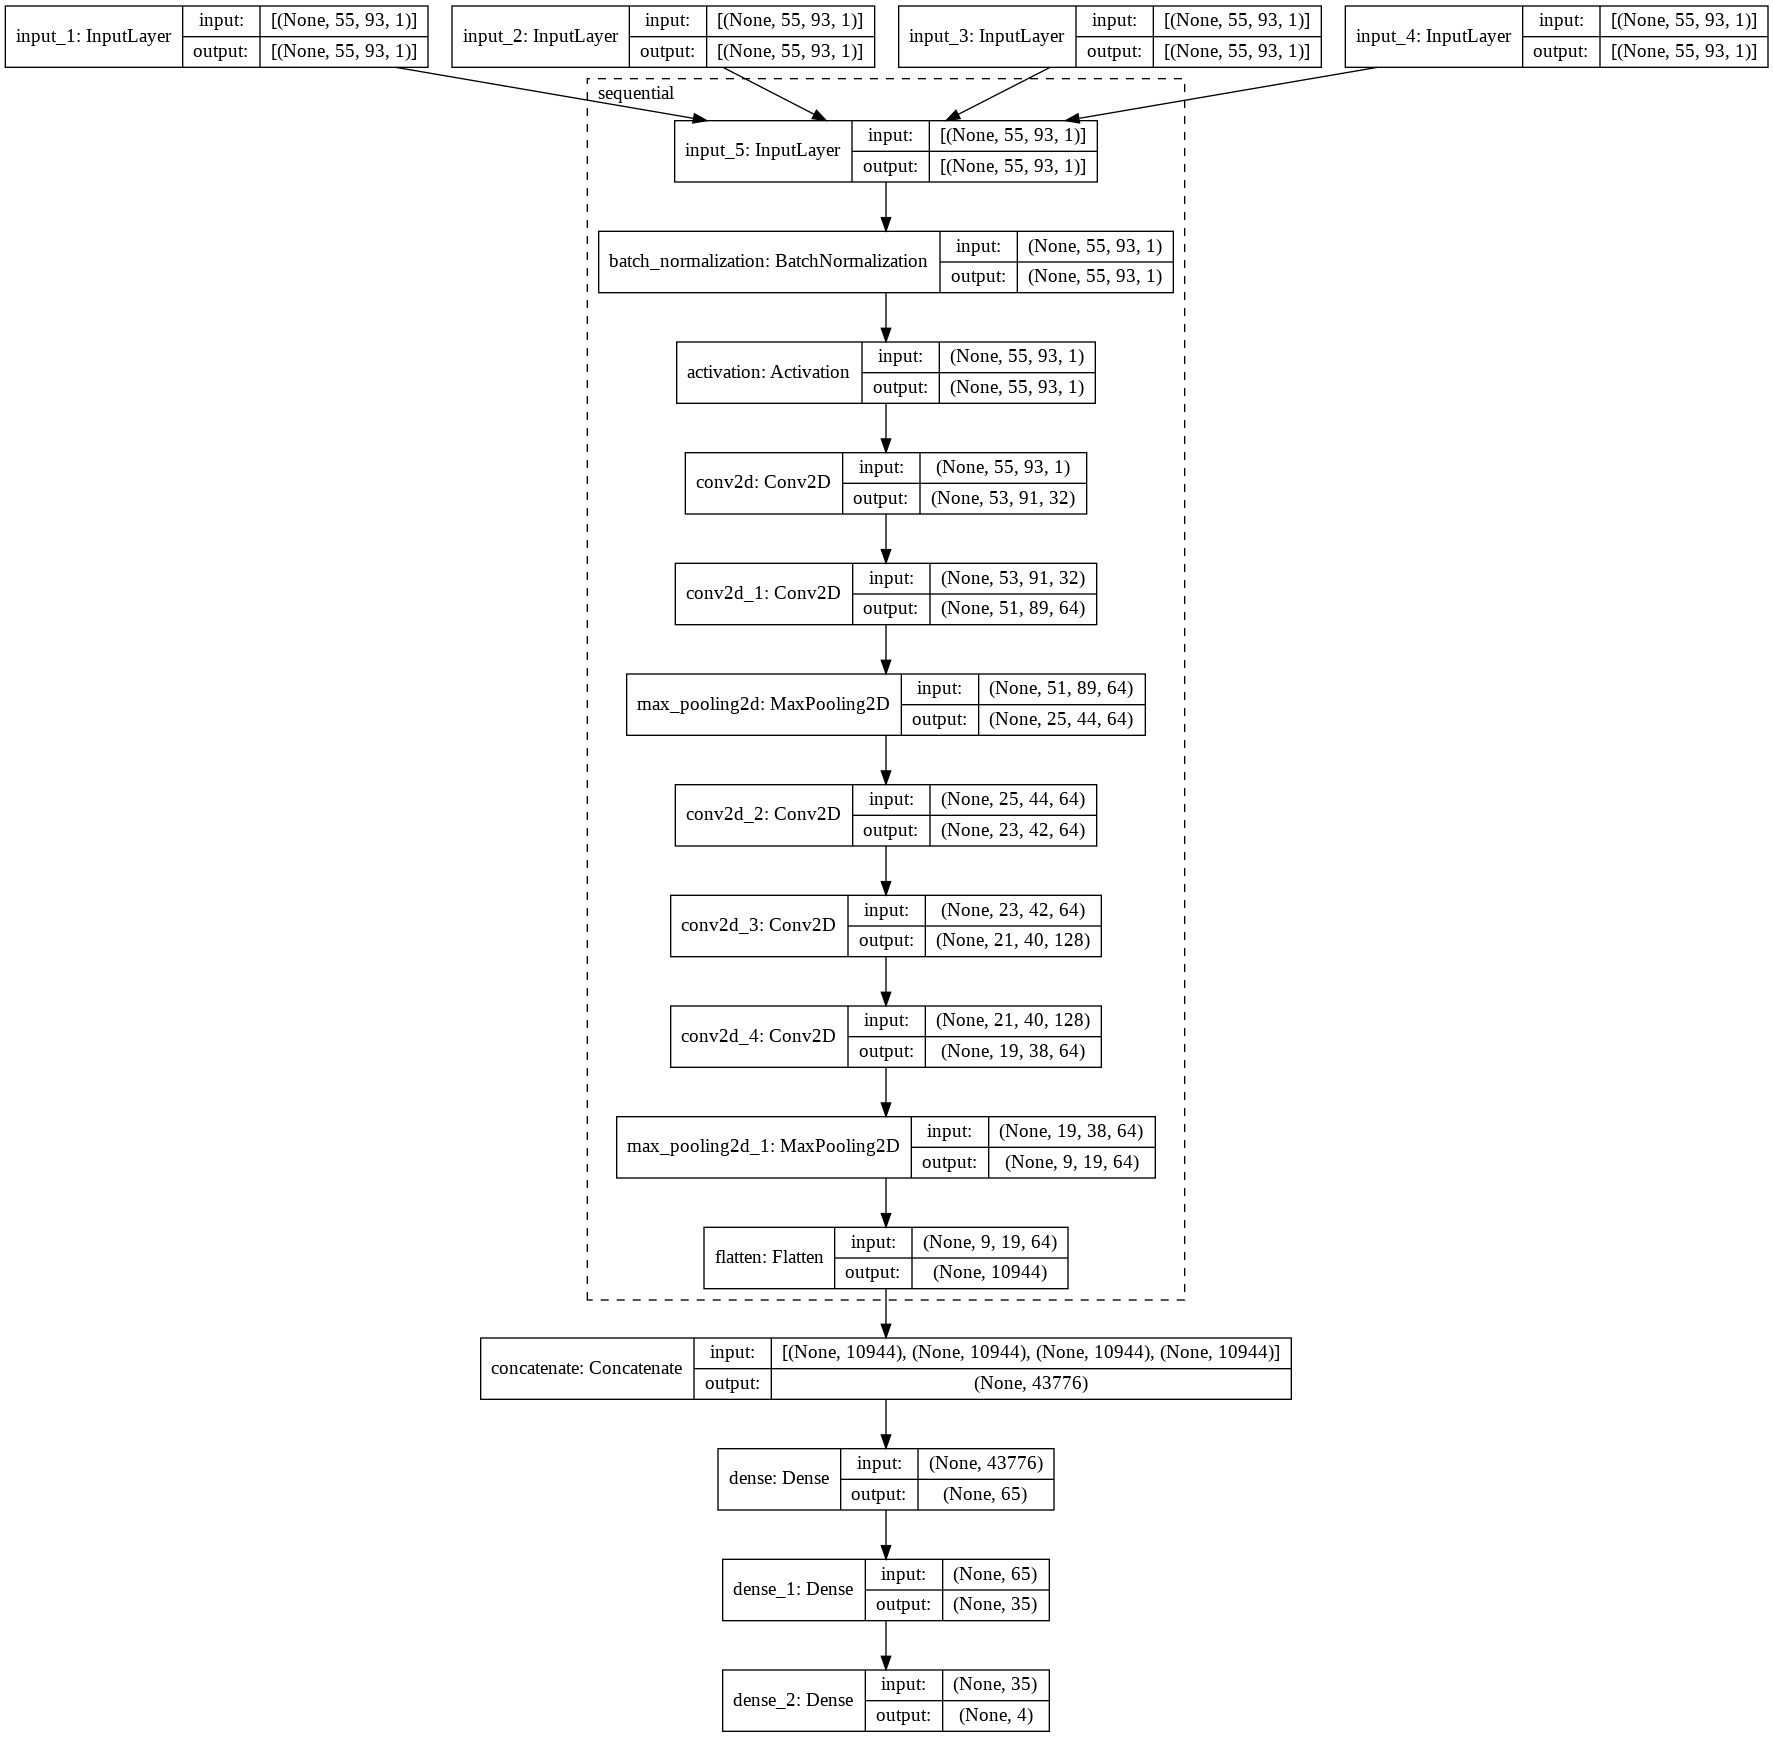

In [ ]:
modelo_input=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/autoencoder_ground_truth_2_largetrain_out5292.h5")

model=model_multi_tel(len_inputs=4,input_shapes=[(55,93,1),(55,93,1),(55,93,1),(55,93,1)],classes=4,learning_rate=1e-4,
                  pre_proces_model=None,last_dense=None,filtros=[[32,64],[64,128,64]],common_pre=True)
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[2,20,35,30,20,30,30],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
                                                    ,labels_asign=[0,1,2,2,2,3,2],lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="all",verbose=True,fill=False)


gamma 1 [1 2] (4, 1999)
gamma 2 [1 2] (4, 1999)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 115)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 106)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 104)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 128)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 128)
electron 6 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 122)
electron 7 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 111)
electron 8 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 95)
electron 9 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 114)
electron 10 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 103)
electron 11 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] (4, 119)
electron 12 [ 1  2  3  4  5  6  7  8  9 10 11 12 

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)
#sin autoencoder
hist=model.fit(x_train,y_train,epochs=56,batch_size=128,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/56
259/259 [==============================] - 55s 213ms/step - loss: 0.3299 - accuracy: 0.9648 - val_loss: 0.2623 - val_accuracy: 0.9784
Epoch 2/56
259/259 [==============================] - 52s 200ms/step - loss: 0.2498 - accuracy: 0.9771 - val_loss: 0.2449 - val_accuracy: 0.9796
Epoch 3/56
259/259 [==============================] - 52s 200ms/step - loss: 0.2280 - accuracy: 0.9818 - val_loss: 0.2355 - val_accuracy: 0.9807
Epoch 4/56
259/259 [==============================] - 52s 201ms/step - loss: 0.2123 - accuracy: 0.9835 - val_loss: 0.2351 - val_accuracy: 0.9777
Epoch 5/56
259/259 [==============================] - 52s 200ms/step - loss: 0.2023 - accuracy: 0.9835 - val_loss: 0.2254 - val_accuracy: 0.9820
Epoch 6/56
259/259 [==============================] - 52s 200ms/step - loss: 0.1894 - accuracy: 0.9859 - val_loss: 0.2060 - val_accuracy: 0.9825
Epoch 7/56
259/259 [==============================] - 52s 200ms/step - loss: 0.1782 - accuracy: 0.9870 - val_loss: 0.1958 - val_ac

259/259 [==============================] - 5s 18ms/step - loss: 0.1024 - accuracy: 0.9847


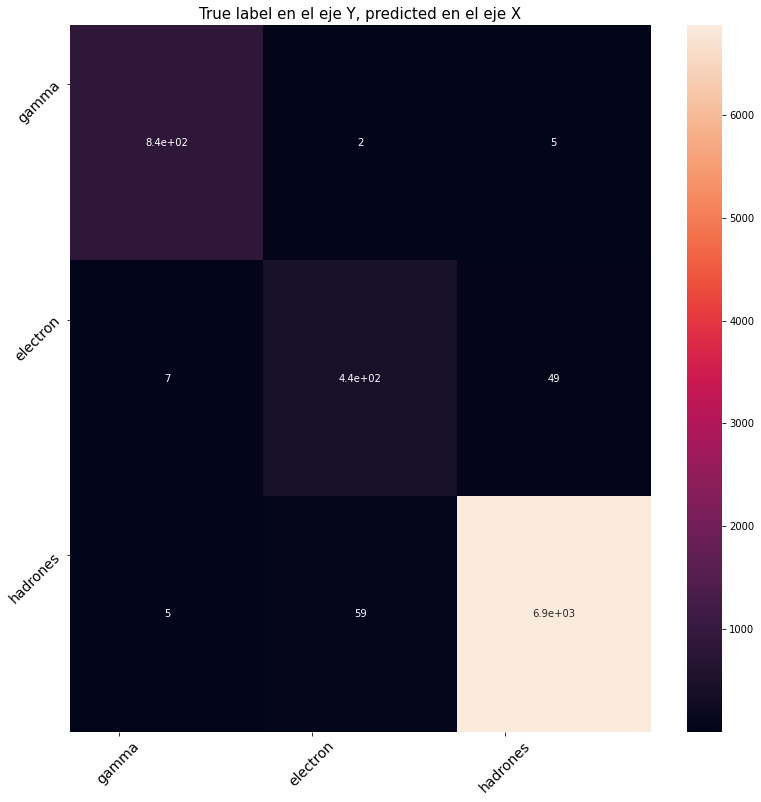

In [ ]:
model.evaluate(x_test,y_test)
comp_and_diplay_conf_matrix(y_test,model.predict(x_test),elements=['gamma', 'electron', 'hadrones'],sin_diag=False)

In [ ]:
#este con autoencoder
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)
#con autoencoder
hist=model.fit(x_train,y_train,epochs=56,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/56
518/518 [==============================] - 57s 105ms/step - loss: 1.7625 - accuracy: 0.8648 - val_loss: 0.9634 - val_accuracy: 0.9523
Epoch 2/56
518/518 [==============================] - 53s 103ms/step - loss: 0.8815 - accuracy: 0.9533 - val_loss: 0.6863 - val_accuracy: 0.9592
Epoch 3/56
518/518 [==============================] - 53s 103ms/step - loss: 0.6434 - accuracy: 0.9606 - val_loss: 0.5297 - val_accuracy: 0.9609
Epoch 4/56
518/518 [==============================] - 53s 103ms/step - loss: 0.5029 - accuracy: 0.9626 - val_loss: 0.4399 - val_accuracy: 0.9629
Epoch 5/56
518/518 [==============================] - 53s 103ms/step - loss: 0.4080 - accuracy: 0.9658 - val_loss: 0.3648 - val_accuracy: 0.9631
Epoch 6/56
518/518 [==============================] - 53s 103ms/step - loss: 0.3312 - accuracy: 0.9712 - val_loss: 0.2999 - val_accuracy: 0.9698
Epoch 7/56
518/518 [==============================] - 53s 103ms/step - loss: 0.2779 - accuracy: 0.9733 - val_loss: 0.2601 - val_ac

259/259 [==============================] - 6s 18ms/step - loss: 0.1169 - accuracy: 0.9756


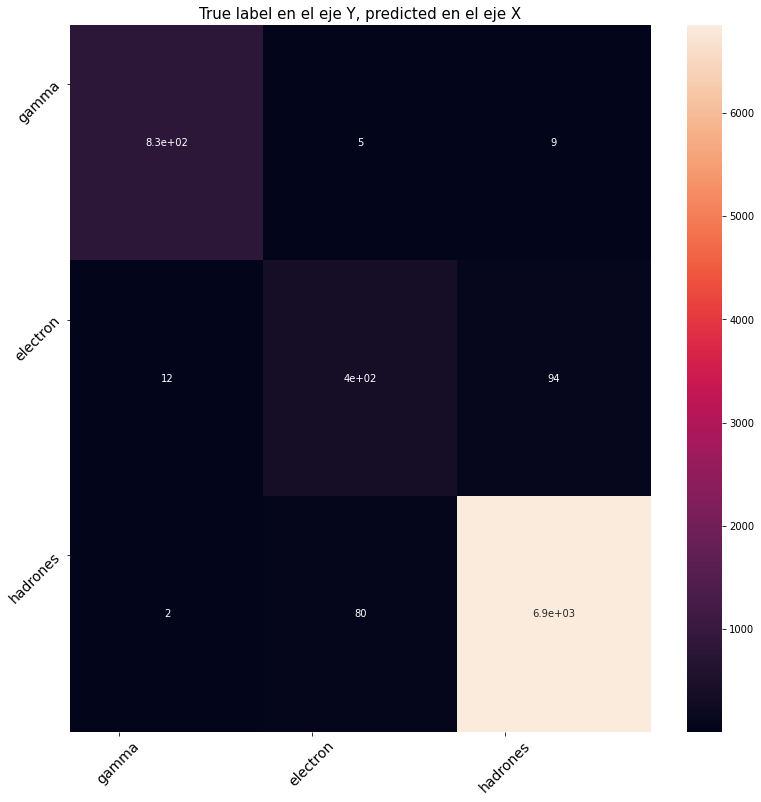

In [ ]:
model.evaluate(x_test,y_test)
comp_and_diplay_conf_matrix(y_test,model.predict(x_test),elements=['gamma', 'electron', 'hadrones'],sin_diag=False)

In [ ]:
modelo_input.trainable=True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 768)          769341      input_5[0][0]                    
                                                                 input_6[0][0]              

In [ ]:
#dejamos que el autoencoder entrene
hist=model.fit(x_train,y_train,epochs=56,batch_size=32,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/56
1036/1036 [==============================] - 71s 66ms/step - loss: 0.0563 - accuracy: 0.9883 - val_loss: 0.1019 - val_accuracy: 0.9763
Epoch 2/56
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0537 - accuracy: 0.9893 - val_loss: 0.1172 - val_accuracy: 0.9751
Epoch 3/56
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0508 - accuracy: 0.9908 - val_loss: 0.0991 - val_accuracy: 0.9797
Epoch 4/56
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0550 - accuracy: 0.9881 - val_loss: 0.1162 - val_accuracy: 0.9767
Epoch 5/56
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0435 - accuracy: 0.9928 - val_loss: 0.0934 - val_accuracy: 0.9809
Epoch 6/56
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0410 - accuracy: 0.9933 - val_loss: 0.0906 - val_accuracy: 0.9785
Epoch 7/56
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0435 - accuracy: 0.9923 - val_loss: 0.0911 -

In [ ]:
#shift a los x_train
x_train_new2=x_train[1:]
x_test_new2=x_test[1:]
x_train_new2.append(x_train[0])
x_test_new2.append(x_test[0])
x_train=[np.concatenate((x_train[i],x_train_new2[i])) for i in range(len(x_train))]
x_test=[np.concatenate((x_test[i],x_test_new2[i])) for i in range(len(x_test))]
y_train=np.concatenate((y_train,y_train))
y_test=np.concatenate((y_test,y_test))
del x_test_new2,x_train_new2

In [ ]:
model.evaluate(x_test,y_test)

In [ ]:
#ahora vamos a probar a cambiar los telescopios entre si para que se haga mas robusto todo
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)



hist=model.fit(x_train,y_train,epochs=56,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop],shuffle=True)


Epoch 1/56
446/446 [==============================] - 33s 74ms/step - loss: 0.4457 - accuracy: 0.8900 - val_loss: 0.4332 - val_accuracy: 0.8891
Epoch 2/56
446/446 [==============================] - 33s 73ms/step - loss: 0.3827 - accuracy: 0.8968 - val_loss: 0.4347 - val_accuracy: 0.8917
Epoch 3/56
446/446 [==============================] - 33s 73ms/step - loss: 0.3487 - accuracy: 0.9003 - val_loss: 0.4569 - val_accuracy: 0.8886
Epoch 4/56
446/446 [==============================] - 33s 73ms/step - loss: 0.3251 - accuracy: 0.9076 - val_loss: 0.4989 - val_accuracy: 0.8820
Epoch 5/56
446/446 [==============================] - 33s 73ms/step - loss: 0.2993 - accuracy: 0.9202 - val_loss: 0.5505 - val_accuracy: 0.8741
Epoch 6/56
446/446 [==============================] - 33s 73ms/step - loss: 0.2729 - accuracy: 0.9340 - val_loss: 0.6308 - val_accuracy: 0.8582
Epoch 7/56
446/446 [==============================] - 33s 73ms/step - loss: 0.2358 - accuracy: 0.9496 - val_loss: 0.7053 - val_accuracy:

446/446 [==============================] - 5s 11ms/step - loss: 0.4191 - accuracy: 0.9034


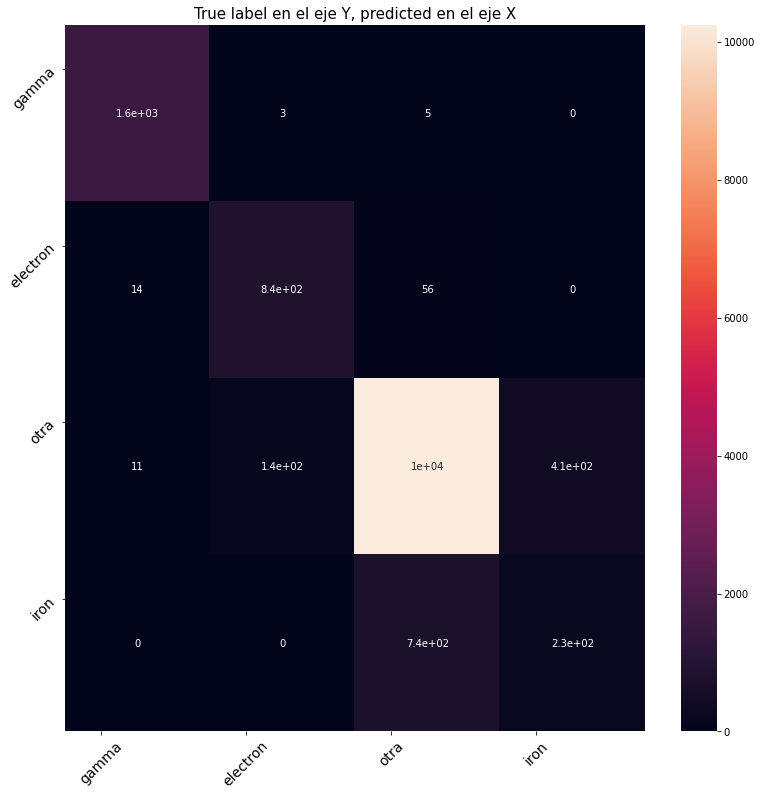

In [ ]:
model.evaluate(x_test,y_test)
comp_and_diplay_conf_matrix(y_test,model.predict(x_test),elements=['gamma', 'electron', 'otra',"iron"],sin_diag=False)

In [ ]:
plot_errors(x_test,y_test,model.predict(x_test),2,3,elementos=['gamma', 'electron', 'proton/helium', 'iron', 'nitrogen', 'silicon'],sort_max=True)

In [ ]:
plot_errors(x_test,y_test,model.predict(x_test),3,2,elementos=['gamma', 'electron', 'proton/helium', 'iron', 'nitrogen', 'silicon'],sort_max=True)

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)

hist=model.fit(x_train,y_train,epochs=56,batch_size=32,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/56
245/245 [==============================] - 15s 62ms/step - loss: 1.9774 - accuracy: 0.5796 - val_loss: 1.9377 - val_accuracy: 0.5838
Epoch 2/56
245/245 [==============================] - 15s 61ms/step - loss: 1.9394 - accuracy: 0.5897 - val_loss: 1.9178 - val_accuracy: 0.5848
Epoch 3/56
245/245 [==============================] - 15s 61ms/step - loss: 1.9349 - accuracy: 0.5867 - val_loss: 1.9226 - val_accuracy: 0.5792
Epoch 4/56
245/245 [==============================] - 15s 61ms/step - loss: 1.9102 - accuracy: 0.6001 - val_loss: 1.9352 - val_accuracy: 0.5827
Epoch 5/56
245/245 [==============================] - 15s 61ms/step - loss: 1.9002 - accuracy: 0.5958 - val_loss: 1.9225 - val_accuracy: 0.5797
Epoch 6/56
245/245 [==============================] - 15s 61ms/step - loss: 1.8878 - accuracy: 0.6024 - val_loss: 1.9031 - val_accuracy: 0.5950
Epoch 7/56
245/245 [==============================] - 15s 61ms/step - loss: 1.8841 - accuracy: 0.6024 - val_loss: 1.9207 - val_accuracy:

62/62 [==============================] - 1s 20ms/step - loss: 1.8937 - accuracy: 0.5930


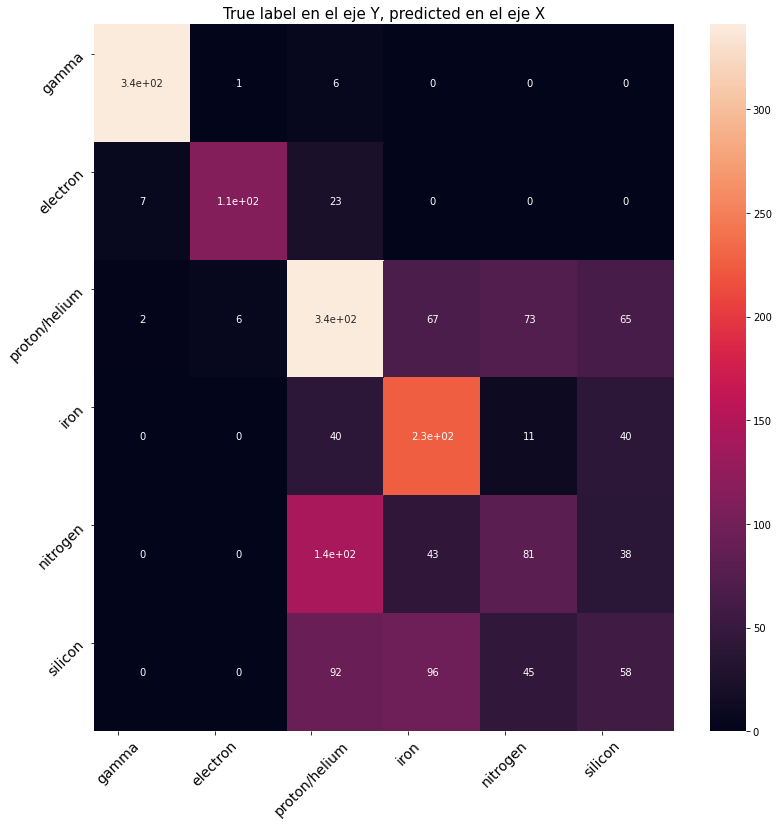

In [ ]:
model.evaluate(x_test,y_test)
comp_and_diplay_conf_matrix(y_test,model.predict(x_test),elements=['gamma', 'electron', 'proton/helium', 'iron', 'nitrogen', 'silicon'],sin_diag=False)

In [ ]:
#vamos a ver como varía el loos conforme variamos el learning rate
#variamos el learning rate de forma logaritmica desde 1e-10 hasta 1e-1
lr_sq=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10e-8*10**(epoch/30))
hist=model.fit(x_train,y_train,epochs=100,batch_size=32,validation_data=(x_test,y_test),callbacks=[lr_sq])


Epoch 1/100
248/248 [==============================] - 23s 86ms/step - loss: 3.3495 - accuracy: 0.2313 - val_loss: 3.3439 - val_accuracy: 0.2432
Epoch 2/100
248/248 [==============================] - 21s 84ms/step - loss: 3.3441 - accuracy: 0.2420 - val_loss: 3.3379 - val_accuracy: 0.2649
Epoch 3/100
248/248 [==============================] - 21s 84ms/step - loss: 3.3386 - accuracy: 0.2639 - val_loss: 3.3315 - val_accuracy: 0.2825
Epoch 4/100
248/248 [==============================] - 21s 84ms/step - loss: 3.3312 - accuracy: 0.2857 - val_loss: 3.3227 - val_accuracy: 0.2997
Epoch 5/100
248/248 [==============================] - 21s 84ms/step - loss: 3.3226 - accuracy: 0.3012 - val_loss: 3.3162 - val_accuracy: 0.3224
Epoch 6/100
248/248 [==============================] - 21s 84ms/step - loss: 3.3156 - accuracy: 0.3135 - val_loss: 3.3059 - val_accuracy: 0.3335
Epoch 7/100
248/248 [==============================] - 21s 84ms/step - loss: 3.3064 - accuracy: 0.3251 - val_loss: 3.2955 - val_ac

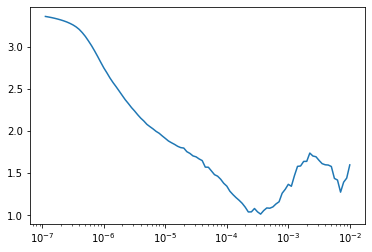

In [ ]:
plt.plot([ 10e-8*10**(epoch/20) for epoch in range(1,101)],hist.history["loss"])
plt.xscale("log")

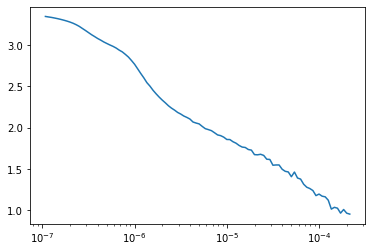

In [ ]:
plt.plot([ 10e-8*10**(epoch/30) for epoch in range(1,101)],hist.history["loss"])
plt.xscale("log")